In [15]:
import pandas as pd
from get_comments import main
from path import Path
import os
import time
from tqdm.auto import tqdm
import numpy as np
import json

In [16]:
df = pd.read_csv('./data/change_org_petitions_Amber_Heard_at_20211005-222550_limit_1000_offset_0_delay_ms_500.csv')
df_manual = pd.read_csv('./data/manual_petition_slugs.csv')
df_status = pd.read_csv('./data/all_petitions_status_manual.csv')

In [17]:
slug_to_status = dict(zip(df_status.slug, df_status.status))

In [18]:
slugs = list(df['petition__slug']) + list(df_manual.slug)
slugs = [x for x in slugs if isinstance(x, str)]
slugs = [x for x in slugs if slug_to_status[x] != 'irrelevant']

In [19]:
len(slugs)

185

In [20]:
error_slugs = set()
for slug in tqdm(slugs):
    if not isinstance(slug, str):
        continue
    args = type('obj', (object,), {'petition_slug': slug, 'delay_ms': 100, 'offset': 0, 'limit': 1000000})
    with Path('./data'):
        try:
            main(args)
        except Exception as e:
            print(slug, e)
            error_slugs.add(slug)

  0%|          | 0/185 [00:00<?, ?it/s]

Petition ID is 20569720
File already exists, doing nothing!
Petition ID is 26062476
File already exists, doing nothing!
Petition ID is 25704328
File already exists, doing nothing!
Petition ID is 25752458
File already exists, doing nothing!
Petition ID is 13641580
File already exists, doing nothing!
Petition ID is 20187467
File already exists, doing nothing!
Petition ID is 26284669
File already exists, doing nothing!
Petition ID is 22874214
File already exists, doing nothing!
Petition ID is 20394746
File already exists, doing nothing!
Petition ID is 14799888
File already exists, doing nothing!
Petition ID is 26583137
File already exists, doing nothing!
Petition ID is 20197634
File already exists, doing nothing!
Petition ID is 23536379
File already exists, doing nothing!
Petition ID is 20376887
File already exists, doing nothing!
Petition ID is 25859415
File already exists, doing nothing!
Petition ID is 25880923
File already exists, doing nothing!
Petition ID is 25743232
File already exi

  0%|          | 0/1000000 [00:00<?, ?it/s]

Data saved to change_org_comments_petition_slug_dc-entertainment-remove-amber-heard-from-aquaman-2_limit_1000000_offset_0_at_20211112-093827_delay_ms_100.csv
Petition ID is 20196023


  0%|          | 0/1000000 [00:00<?, ?it/s]

Data saved to change_org_comments_petition_slug_l-oréal-remove-amber-heard-as-l-oreal-spokesperson_limit_1000000_offset_0_at_20211112-094433_delay_ms_100.csv


In [21]:
# first two are not relevant
# the second one does not have public milestones
error_slugs

set()

In [22]:
# merging everything into a single dataframe

In [23]:
l = os.listdir('./data')
fs = []
prefix = 'change_org_comments_petition_slug_'
for filename in l:
    f = os.path.basename(filename)
    
    if not(filename.startswith(prefix) and filename.endswith('.csv')):
        continue
    slug = f[len(prefix):f.index('_limit_')]
    # print(slug)
    if slug not in slugs:
        continue
    fs.append('./data/' + filename)

In [24]:
def read_set_slug(f):
    try:
        df = pd.read_csv(f)
        slug = os.path.basename(f)[len(prefix):f.index('_limit_') + 1]
        df['petition__slug'] = [slug] * len(df)
        return df
    except:
        return None

In [25]:
df = pd.concat([read_set_slug(f) for f in tqdm(fs)])
df = df.reset_index()

  0%|          | 0/183 [00:00<?, ?it/s]

In [26]:
for c in df.columns:
    if c.startswith('commentable_entity') and c != 'commentable_entity.slug':
        del df[c]

In [27]:
df['status_manual'] = [slug_to_status[t] for t in df['commentable_entity.slug']]
df.to_csv(f"./data/all_petitions_comments_{time.strftime('%Y%m%d-%H%M%S')}.csv", index=False)

In [28]:
column_size = {c: len(json.dumps(list(df[c]))) for c in tqdm(df.columns)}

  0%|          | 0/45 [00:00<?, ?it/s]

In [29]:
from collections import Counter
Counter(column_size).most_common()

[('comment', 4641692),
 ('petition__slug', 1640808),
 ('commentable_entity.slug', 1422904),
 ('user.photo.sizes.medium.url', 741938),
 ('user.photo.sizes.large.url', 741938),
 ('user.photo.sizes.xlarge.url', 741938),
 ('user.photo.sizes.small.url', 726406),
 ('created_at', 653712),
 ('user.display_name', 521749),
 ('user.photo.url', 462362),
 ('user.slug', 354818),
 ('user.city', 328738),
 ('user.last_name', 312819),
 ('user.id', 307666),
 ('role', 301984),
 ('id', 299618),
 ('status_manual', 297962),
 ('user.short_display_name', 290660),
 ('user.first_name', 290644),
 ('commentable_id', 272179),
 ('user.locale', 248136),
 ('commentable_type', 245142),
 ('user.photo.id', 194608),
 ('user.description', 192664),
 ('user.roles', 163428),
 ('user.country_code', 163420),
 ('user.website', 162072),
 ('user.photo.sizes.medium.size.width', 151722),
 ('user.photo.sizes.medium.size.height', 151722),
 ('user.photo.sizes.large.size.width', 151722),
 ('user.photo.sizes.large.size.height', 151722),


# Optional: plotting

In [30]:
from matplotlib import pyplot as plt

In [31]:
sum([len(t) for t in df.comment])

4335398

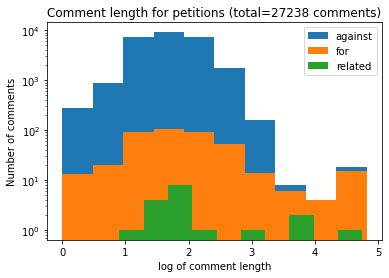

In [32]:
plt.title("Comment length for petitions (total=%d comments)" % len(df))
plt.xlabel("log of comment length")
plt.ylabel("Number of comments")
for status, group in df.groupby('status_manual'):
    plt.hist([np.log10(len(t)) for t in group.comment], label=status)#, log=True)
plt.legend()
plt.yscale('log')
plt.savefig('./figures/comments_length_hist.png', bbox_inches='tight')
plt.show()

(array([1.7100e+02, 7.0000e+00, 1.9000e+01, 4.0000e+00, 1.9700e+02,
        1.0000e+02, 1.5470e+03, 2.1710e+03, 2.0471e+04, 2.5510e+03]),
 array([16950.37990741, 17149.69558449, 17349.01126157, 17548.32693866,
        17747.64261574, 17946.95829282, 18146.27396991, 18345.58964699,
        18544.90532407, 18744.22100116, 18943.53667824]),
 <BarContainer object of 10 artists>)

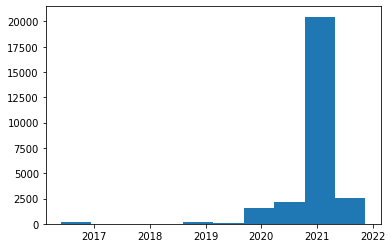

In [33]:
plt.hist(pd.to_datetime(df.created_at))